<a href="https://colab.research.google.com/github/baveet256/Pytorch-DL/blob/main/Face_emotion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Nov  9 13:13:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from pathlib import Path
dir_path = Path("/content/drive/MyDrive/Face_Dataset")
unzip_path = dir_path / "unzipped"

if unzip_path.is_dir():
    print("is there")
else:  
  unzip_path.mkdir(parents=True, exist_ok=True)
  with zipfile.ZipFile("/content/drive/MyDrive/ Face_Dataset/archive.zip") as f:
    f.extractall(unzip_path)

is there


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

In [ ]:
from pathlib import Path
data_path = Path("/content/drive/MyDrive/Face_Dataset/unzipped")

In [ ]:
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() 
])

In [ ]:
train_dir = data_path / "train"
test_dir = data_path / "test"

In [ ]:
train_dir

PosixPath('/content/drive/MyDrive/Face_Dataset/unzipped/train')

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28709
    Root location: /content/drive/MyDrive/Face_Dataset/unzipped/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 7178
    Root location: /content/drive/MyDrive/Face_Dataset/unzipped/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
train_data[0][0].shape

torch.Size([1, 48, 48])

In [ ]:
# to visualize we will do matplotlib
import matplotlib.pyplot as plt

torch.Size([48, 48])


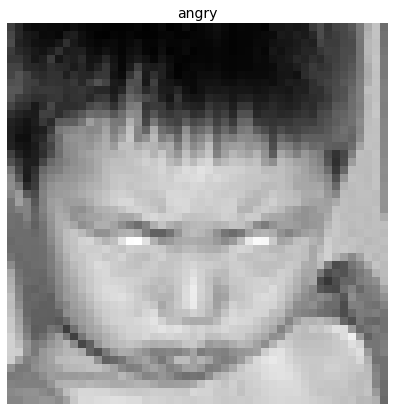

In [ ]:
img,label = train_data[0][0],train_data[0][1]
img_new = img.permute(1,2,0).squeeze(dim=2)
print(img_new.shape)
plt.figure(figsize=(10, 7))
plt.imshow(img_new, cmap='gray')
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=32,shuffle=False)

In [ ]:
class Emotionmodel(nn.Module):
  def __init__(self,input_channels:int,out_channel:int):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
      nn.Conv2d(in_channels=input_channels,out_channels=32, kernel_size = 3, padding =1, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=32,out_channels=64, kernel_size = 3, padding =1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(p=0.25),
    )
    self.layer_stack2 = nn.Sequential(
      nn.Conv2d(in_channels=64,out_channels=128, kernel_size = 3, padding =1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels=128,out_channels=128, kernel_size = 3, padding =1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(p=0.25),
    )
    self.layer_stack3 = nn.Sequential(
      nn.Flatten(),
      # 6x6= 36
      #we checked the in features by multiplication in between them.
      nn.Linear(in_features =36*128,out_features=256),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features =256 ,out_features=7),
      nn.Softmax(dim=1)
    )
  def forward(self,x):
    x = self.layer_stack1(x)
    #print(x.shape)
    #x = x.unsqueeze(dim=0)
    #print(x.shape)
    x = self.layer_stack2(x)
    #print(x.shape)
    #f = nn.Flatten()
    #o=f(x)
    #print(o.shape)
    x = self.layer_stack3(x)
    #print(x.shape)
    return x

In [ ]:
torch.manual_seed(42)
model_conv = Emotionmodel(1,out_channel = len(train_data.classes)).to(device)
model_conv

Emotionmodel(
  (layer_stack1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (layer_stack2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
  )
  (layer_stack3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=25

In [ ]:
img = img.to(device)
img.shape

torch.Size([1, 48, 48])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_conv.parameters(),lr=0.1,weight_decay = 1e-6)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
def train_time(start: float,end: float,device:torch.device = None):
  tot_time = end - start
  print(f"time taken:{tot_time:.3f} seconds , on device:{device}")
  return tot_time


In [ ]:
def train_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
  train_loss,train_acc =0,0
  #model.train()
  for batch_number ,(X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    # loss for every batches  
    train_loss+=loss
    train_acc +=accuracy_fn(y,y_pred.argmax(dim=1))  
    #optimitzer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               accuracy_fn,
               device:torch.device=device):
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device),y.to(device)
      test_pred = model(X)
      test_loss+=loss_fn(test_pred,y)
      test_acc+=accuracy_fn(y,test_pred.argmax(dim=1))
    test_loss/=len(data_loader)
    test_acc/=len(data_loader)
    print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n") 

In [ ]:
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
   #return dictionary of results
  loss,acc=0,0
  with torch.inference_mode():
    for X,y in data_loader:
      eval_pred = model(X)
      loss +=loss_fn(eval_pred,y) 
      acc  +=accuracy_fn(y,eval_pred.argmax(dim=1))
    loss /=len(data_loader)
    acc /=len(data_loader)
  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}   

In [ ]:
torch.manual_seed(42)
start_time=timer()
epochs = 1
for epoch in tqdm(range(epochs)):
   print(f"Epoch: {epoch}\n---------")
   train_step(model_conv,train_dataloader,loss_fn,optimizer,accuracy_fn,device)
   test_step(model_conv,test_dataloader,loss_fn,accuracy_fn,device)
end_time = timer()
train_time(start_time,end_time,device)   

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
---------
